# Climate Analysis and Exploration

In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
# Path to sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Precipitation Analysis

In [13]:
# Collect the names of tables within the database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [14]:
# Using the inspector to print the column names within both tables and its types
print("Measurement table:")
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

print("-----")

print("Station table:")
column2 = inspector.get_columns('station')
for column in column2:
    print(column["name"], column["type"])

Measurement table:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----
Station table:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [16]:
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [17]:
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
trailing_year= session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()


Trailing_year=pd.DataFrame(trailing_year).fillna(0)
Trailing_year.head()


,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,0.00
4,2016-08-24,1.22


In [19]:
# Group By
Rain_per_day=Trailing_year.groupby(["date"]).sum()
Rain_per_day.reset_index().head()

,date,prcp
0,2016-08-24,9.33
1,2016-08-25,0.54
2,2016-08-26,0.10
3,2016-08-27,0.32
4,2016-08-28,3.10


<function matplotlib.pyplot.show(*args, **kw)>

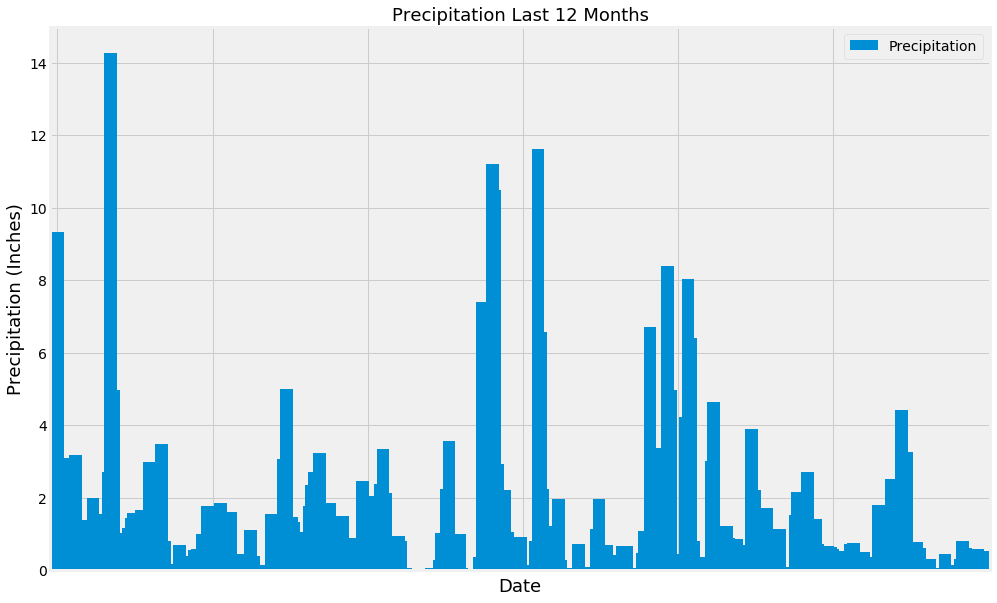

In [43]:
# Use Pandas Plotting with Matplotlib to plot the data
ax =Rain_per_day.plot(kind='bar', width=5, figsize=(15,10))
plt.locator_params(axis='x', nbins=6)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=14)
ax.grid(True)
plt.legend(["Precipitation"], fontsize="14")
plt.title("Precipitation Last 12 Months", size=18)
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
plt.show

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data per day
Rain_per_day.describe()


,prcp
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [22]:
#for entire dataset
Trailing_year.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


## Station Analysis

In [23]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
#max,min,avg for all stations
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
temp_info = session.query(*sel).\
    group_by(Measurement.station).all()
temp_info

[('USC00511918', 53.0, 87.0, 71.61596766043456),
 ('USC00513117', 59.0, 85.0, 72.68918420081211),
 ('USC00514830', 58.0, 85.0, 74.8732970027248),
 ('USC00516128', 58.0, 84.0, 70.91500765696784),
 ('USC00517948', 58.0, 87.0, 74.68440233236151),
 ('USC00518838', 58.0, 83.0, 72.72407045009784),
 ('USC00519281', 54.0, 85.0, 71.66378066378067),
 ('USC00519397', 56.0, 87.0, 74.55323054331865),
 ('USC00519523', 56.0, 85.0, 74.5436493068565)]

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
best = active_stations[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == best).all()

[(54.0, 71.66378066378067, 85.0)]

In [27]:
#Choose the station with the highest number of temperature observations.
Most_obs= session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).limit(1).all()
Most_obs

[('USC00519281', 2772)]

In [28]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Most_obs_year= session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station== best).\
    filter(Measurement.date > last_year).all()
Most_observed=pd.DataFrame(Most_obs_year)
Most_observed.set_index("station").head()



,tobs
station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


<function matplotlib.pyplot.show(*args, **kw)>

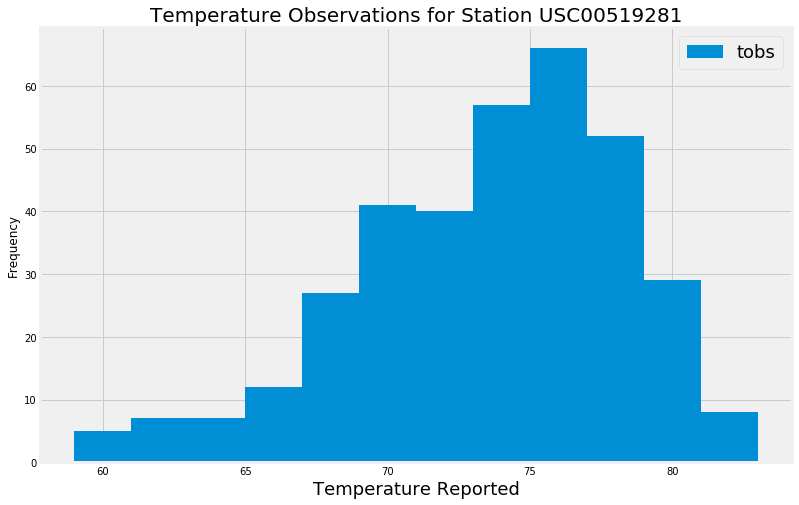

In [29]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Most_observed.plot.hist(by='station', bins=12, figsize=(12,8))
plt.title("Temperature Observations for Station " + best, fontsize=20)
plt.xlabel("Temperature Reported", fontsize=18)
plt.legend(bbox_to_anchor=(1,1), fontsize=18)
plt.grid
plt.show

## Part 2- Climate App

In [32]:
#located in app.py

## Other Recommended Analyses

### Temperature Analysis

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()



In [35]:
my_trip_results = calc_temps('2017-07-08', '2017-07-16')
my_trip_results

[(69.0, 78.3103448275862, 82.0)]

In [36]:
#DataFrame
Trip=pd.DataFrame(my_trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])

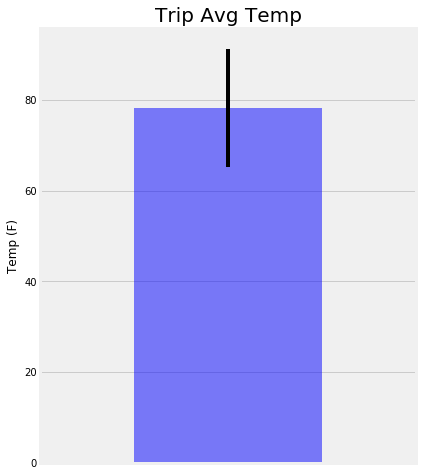

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp = Trip['Avg Temp']
min_max_temp = Trip.iloc[0]['Max Temp'] - Trip.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='blue')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid
plt.show()

### Daily Rainfall Averages

In [38]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
Total_rainfall= session.query(Measurement.station, Measurement.prcp).\
    filter(Measurement.date <='2017-07-16').\
    filter(Measurement.date >= '2017-07-08').\
    group_by(Measurement.station).\
    order_by(Measurement.prcp.desc()).all()
TR=pd.DataFrame(Total_rainfall).fillna(0)
TR

,station,prcp
0,USC00514830,0.06
1,USC00513117,0.02
2,USC00516128,0.02
3,USC00519281,0.00
4,USC00519397,0.00
5,USC00519523,0.00
6,USC00517948,0.00


In [39]:
#Get station Info
Station_info= session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.date <='2017-07-16').\
    filter(Measurement.date >= '2017-07-08').\
    group_by(Station.station).all()
TS=pd.DataFrame(Station_info).fillna(0)
TS

,station,name,latitude,longitude,elevation
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


In [40]:
#Merged two DFs together
Merged=pd.merge(TR, TS, on="station", how="inner")
Merged

,station,prcp,name,latitude,longitude,elevation
0,USC00514830,0.06,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
1,USC00513117,0.02,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00516128,0.02,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,USC00519281,0.00,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
4,USC00519397,0.00,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,USC00519523,0.00,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00517948,0.00,"PEARL CITY, HI US",21.39340,-157.97510,11.9
